# <center> Motivating example of the Arizona PV recycling landscape - Agent-Based Modeling </center>

The motivating example is using a modified version of the Mesa Tutorial and the information on WG3 slides (and is inspired from the PV ABM) to start thinking how we integrate the RTN and ABM models.

In [87]:
from mesa import Agent, Model
from mesa.time import RandomActivation
%matplotlib inline
import matplotlib.pyplot as plt
from enum import Enum
import math
import networkx as nx
from mesa.datacollection import DataCollector
from mesa.space import NetworkGrid
import numpy as np
import pandas as pd
import random

## Creating agent types

In [88]:
class AssetOwnerAgent(Agent):
    """Agent that owns some PV."""
    def __init__(self, unique_id, model):
        """Initiate agent.
        
        Args:
            unique_id (int): agent #, also relate to the node # in the network.
            model (class instance): the agent class inherit the model class.
        """
        super().__init__(unique_id, model)
        self.pv_waste = self.model.pv_waste
        dice = random.random()
        if dice < self.model.initial_recycling_rate:
            self.recycling = True
        else:
            self.recycling = False

    def normalize_scores(self, *args):
        """Normalize scores to the option with the highest score.
        
        Args:
            *args (floats): scores that need to be normalized.
        
        Returns:
            list: the list of normalized scores.
        """
        list_scores = []
        for arg in args:
            list_scores.append(arg)
        max_score = max(list_scores)
        normalized_scores = []
        for score in list_scores:
            score = score / max_score
            normalized_scores.append(score)
        return normalized_scores
            
    def eol_pathway_decision(self, recycling_costs, landfill_costs, grid):
        """Agent decision-making function.
        
        Args:
            recycling_costs (list): recycling costs.
            landfill_costs (float): landfill costs.
            grid (Mesa grid object building on a Networkx graph): social network relating asset owner agents. 
        """
        # Collate (minimum) recycling cost and landfill cost and normalize values as to not skew decision (both peer effect
        # scores and cost scores should be between 0 and 1, the weights define which factors has more influence).
        cost_scores = self.normalize_scores(min(recycling_costs), landfill_costs)
        # Get all the agent neighbors (in the social network) in a list.
        neighbors_nodes = grid.get_neighbors(self.unique_id, include_center=False)
        # Assign a score to the recycling and landfill behavior depending on the number of neighbors that have adopted that 
        # behavior (e.g., if all neighbors recycle: peers_scores = [1, 0] if they all landfill: peers_scores = [0, 1]).
        peers_scores = []
        for recycling in [True, False]:
            list_agent_behavior = [
                agent for agent in grid.get_cell_list_contents(neighbors_nodes) if
                getattr(agent, 'recycling') == recycling]
            if len(neighbors_nodes) != 0:
                peers_score = len(list_agent_behavior) / len(neighbors_nodes)
            else:
                peers_score = 0
            peers_scores.append(peers_score)
        # Compute total scores accounting for the weight of each factor.
        total_scores = [self.model.decision_weights['costs'] * x + self.model.decision_weights['peers'] * y 
                        for x, y in zip(cost_scores, peers_scores)]
        # Agent chooses the decision with the highest total score (total_scores[0] and total_scores[1] correspond to the 
        # score attributed to the recycling and landfill behaviors respectively).
        decision = total_scores.index(max(total_scores))
        if decision == 0:
            self.recycling = True
        else:
            self.recycling = False
    
    def update_collector(self):
        """Update simulation outputs collector."""
        if self.recycling:
            self.model.pv_waste_flows['recycling'] += 1
        else:
            self.model.pv_waste_flows['landfill'] += 1
        
    def step(self):
        """Evolution of agent at each step."""
        self.eol_pathway_decision(self.model.recycling_center_costs, self.model.landfill_costs, self.model.grid)
        self.update_collector()

In [89]:
class RecyclingCenterAgent(Agent):
    """Agent that recycle PV."""
    def __init__(self, unique_id, model):
        """Initiate agent.
        
        Args:
            unique_id (int): agent #.
            model (class instance): the agent class inherit the model class.
        """
        super().__init__(unique_id, model)
        self.name = self.model.recycling_center_names[self.unique_id]
        
    def step(self):
        """Evolution of agent at each step."""
        # print(self.name)
        pass

In [90]:
class ManufacturingCenterAgent(Agent):
    """Agent that manufacture PV."""
    def __init__(self, unique_id, model):
        """Initiate agent.
        
        Args:
            unique_id (int): agent #.
            model (class instance): the agent class inherit the model class.
        """
        super().__init__(unique_id, model)
        self.name = self.model.manufacturing_center_names[self.unique_id]
        
    def step(self):
        """Evolution of agent at each step."""
        # print(self.name)
        pass

In [91]:
class CollectionCenterAgent(Agent):
    """Agent that collect PV."""
    def __init__(self, unique_id, model):
        """Initiate agent.
        
        Args:
            unique_id (int): agent #.
            model (class instance): the agent class inherit the model class.
        """
        super().__init__(unique_id, model)
        self.name = self.model.collection_center_names[self.unique_id]
        
    def step(self):
        """Evolution of agent at each step."""
        # print(self.name)
        pass

## Creating the model

In [92]:
class MotivatingExampleModel(Model):
    """A model with some number of agents. Creates and activates agents. Also defines inputs (default values can be 
    changed by user) and collect outputs."""
    def __init__(self, seed=None, num_asset_owners=20, pv_waste=1, landfill_costs=0.2, recycling_center_costs={
                'Fabtech': 1, 'First Solar': 2, 'WERECYCLESOLAR': 3}, manufacturing_center_costs={'Meywer Burger': 1}, 
                 collection_center_costs={'ADT Solar': 1, 'SunPower': 2, 'Independent Solar': 3}, initial_recycling_rate=0.1, 
                 social_network={'node_degree': 7, 'rewiring_prob': 0.1}, decision_weights={'costs': -0.5, 'peers': 0.5}):
        """Initiate model.
        
        Args:
            seed (int, optional): number used to initialize the random generator. Defaults to None.
            num_asset_owners (int): number of asset owners. Default to 20.
            pv_waste (float): amount of annual PV waste per asset owner. Default to 1.
            landfill_costs (float): amount of annual PV waste per asset owner. Default to 0.2.
            recycling_center_costs (dict): names and costs of different recyclers. Default to {
                'Fabtech': 1, 'First Solar': 2, 'WERECYCLESOLAR': 3}.
            manufacturing_center_costs (dict): names and costs of different manufacturers. Default to {'Meywer Burger': 1}.
            collection_center_costs (dict): names and costs of different collectors. Default to {
                'ADT Solar': 1, 'SunPower': 2, 'Independent Solar': 3}.
            initial_recycling_rate (float): intial proportion of asset owners that recycled their PV waste. Default to 0.1.
            social_network (dict): parameters to draw a small-world network. Default to social_network={
                'node_degree': 7, 'rewiring_prob': 0.1}.
            decision_weights: weights of the different factors influencing asset owners to recycle PV. Default to {
                'costs': -0.5, 'peers': 0.5}
        """
        
        # Fixing random generator
        self.seed = seed
        random.seed(self.seed)
        
        # Variables from inputs (value defined externally)
        self.num_asset_owners = num_asset_owners
        self.pv_waste = pv_waste
        self.landfill_costs = landfill_costs
        self.num_recycling_centers = len(recycling_center_costs)
        self.num_manufacturing_centers = len(manufacturing_center_costs)
        self.num_collection_centers = len(collection_center_costs)
        self.recycling_center_names = list(recycling_center_costs.keys())
        self.recycling_center_costs = list(recycling_center_costs.values())
        self.manufacturing_center_names = list(manufacturing_center_costs.keys())
        self.manufacturing_center_costs = list(manufacturing_center_costs.values())
        self.collection_center_names = list(collection_center_costs.keys())
        self.collection_center_costs = list(collection_center_costs.values())
        self.initial_recycling_rate = initial_recycling_rate
        self.social_network = social_network
        self.decision_weights = decision_weights
        
        # Internal variables
        self.asset_owners_schedule = RandomActivation(self)
        self.recycling_centers_schedule = RandomActivation(self)
        self.manufacturing_centers_schedule = RandomActivation(self)
        self.collection_centers_schedule = RandomActivation(self)
        self.pv_waste_flows = {'recycling': 0, 'landfill': 0}
        
        # Create social network and Mesa grid
        self.network = nx.watts_strogatz_graph(self.num_asset_owners, self.social_network['node_degree'],
                                          self.social_network['rewiring_prob'], seed=random.seed(self.seed))
        self.grid = NetworkGrid(self.network)
        
        def create_agents(schedule, num_agents, agent_type):
            for i in range(num_agents):
                a = agent_type(i, self)
                schedule.add(a)
                if agent_type == AssetOwnerAgent:
                    self.grid.place_agent(a, i)
        
        # Create agents
        create_agents(self.asset_owners_schedule, self.num_asset_owners, AssetOwnerAgent)
        create_agents(self.recycling_centers_schedule, self.num_recycling_centers, RecyclingCenterAgent)
        create_agents(self.manufacturing_centers_schedule, self.num_manufacturing_centers, ManufacturingCenterAgent)
        create_agents(self.collection_centers_schedule, self.num_collection_centers, CollectionCenterAgent)
        
    def step(self):
        """Advance the model by one step."""
        self.asset_owners_schedule.step()
        self.recycling_centers_schedule.step()
        self.manufacturing_centers_schedule.step()
        self.collection_centers_schedule.step()

## Running the model

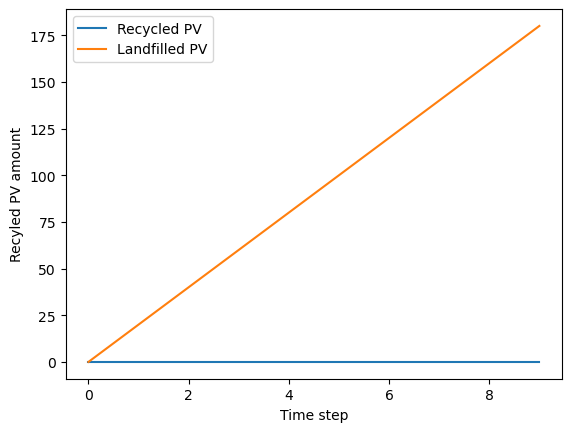

In [104]:
seed = 0
model = MotivatingExampleModel(seed=seed)
recycled_pv = []
landfilled_pv = []

# Run the model for ten steps.
for i in range(10):
    recycled_pv.append(model.pv_waste_flows['recycling'])
    landfilled_pv.append(model.pv_waste_flows['landfill'])
    model.step()

# Plot results.
plt.plot(recycled_pv, label='Recycled PV')
plt.plot(landfilled_pv, label='Landfilled PV')
plt.xlabel('Time step')
plt.ylabel('Recyled PV amount')
plt.legend()

In this baseline scenario, with an equal weight between the peer effect and costs and a low initial adoption of recycling, agents landfill their end-of-life PV panels. **What if only peer effects matters?**

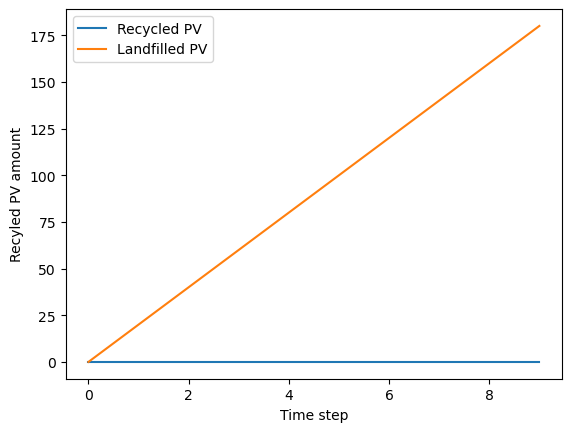

In [94]:
seed = 0
model = MotivatingExampleModel(seed=seed, decision_weights={'costs': -0.0, 'peers': 1})
recycled_pv = []
landfilled_pv = []

# Run the model for ten steps.
for i in range(10):
    recycled_pv.append(model.pv_waste_flows['recycling'])
    landfilled_pv.append(model.pv_waste_flows['landfill'])
    model.step()

# Plot results.
plt.plot(recycled_pv, label='Recycled PV')
plt.plot(landfilled_pv, label='Landfilled PV')
plt.xlabel('Time step')
plt.ylabel('Recyled PV amount')
plt.legend()

Because the **initial recycling rate is 10%** peer effects is not in favor of recycling. However, if only peer effect matters and the initial recycling rate is higher...

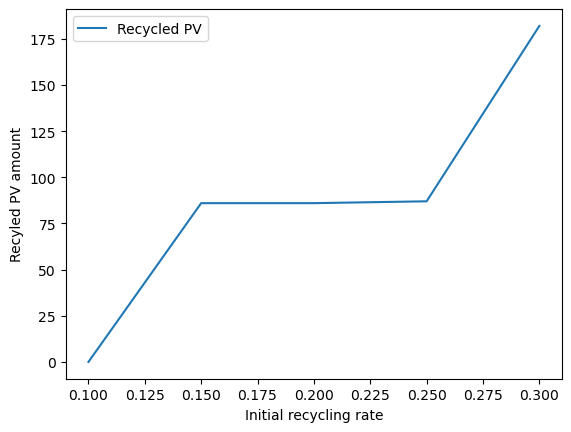

In [95]:
seed = 0
initial_recycling_rates = [0.1, 0.15, 0.20, 0.25, 0.30]
final_recycling_rates = []

# Run the model for ten steps for different initial recycling rates.
for initial_recycling_rate in initial_recycling_rates:
    model = MotivatingExampleModel(seed=seed, decision_weights={'costs': -0.0, 'peers': 1}, 
                                   initial_recycling_rate=initial_recycling_rate)
    for i in range(10):
        model.step()
    final_recycling_rates.append(model.pv_waste_flows['recycling'])

# Plot results.
plt.plot(initial_recycling_rates, final_recycling_rates, label='Recycled PV')
plt.xlabel('Initial recycling rate')
plt.ylabel('Recyled PV amount')
plt.legend()

If **only costs matter** and landfill costs are higher...

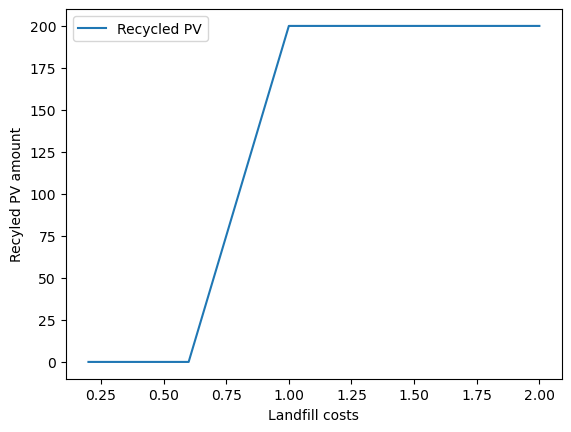

In [96]:
seed = 0
landfill_costs = [0.2, 0.6, 1, 1.4, 2]
final_recycling_rates = []

# Run the model for ten steps for different landfill costs.
for landfill_cost in landfill_costs:
    model = MotivatingExampleModel(seed=seed, decision_weights={'costs': -1.0, 'peers': 0.0}, 
                                   landfill_costs=landfill_cost)
    for i in range(10):
        model.step()
    final_recycling_rates.append(model.pv_waste_flows['recycling'])

# Plot results.
plt.plot(landfill_costs, final_recycling_rates, label='Recycled PV')
plt.xlabel('Landfill costs')
plt.ylabel('Recyled PV amount')
plt.legend()

But both costs and peer effects influence agents' decision. **Overall, because the initial recycling rate is low, peer effect encourages landfill behaviors.** A landfill costs higher than parity (in the example below 1.2 to 1) is necessary for agents to adopt recycling behaviors.

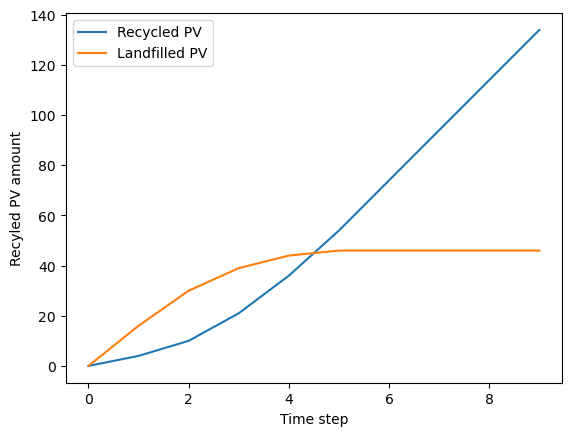

In [97]:
seed = 0
model = MotivatingExampleModel(seed=seed, initial_recycling_rate=0.1, landfill_costs=1.2, 
                               decision_weights={'costs': -0.5, 'peers': 0.5})
recycled_pv = []
landfilled_pv = []

# Run the model for ten steps.
for i in range(10):
    recycled_pv.append(model.pv_waste_flows['recycling'])
    landfilled_pv.append(model.pv_waste_flows['landfill'])
    model.step()

# Plot results.
plt.plot(recycled_pv, label='Recycled PV')
plt.plot(landfilled_pv, label='Landfilled PV')
plt.xlabel('Time step')
plt.ylabel('Recyled PV amount')
plt.legend()

How does it look like in terms of the agents?

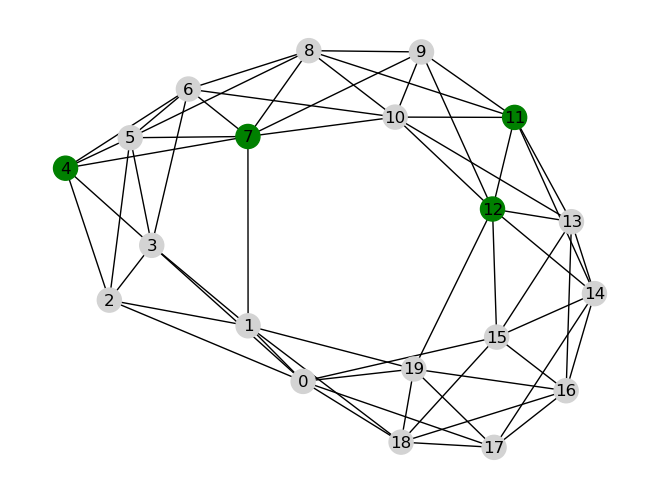

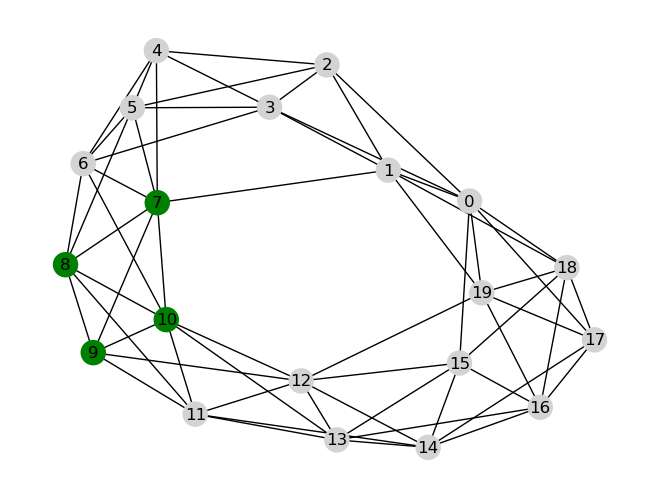

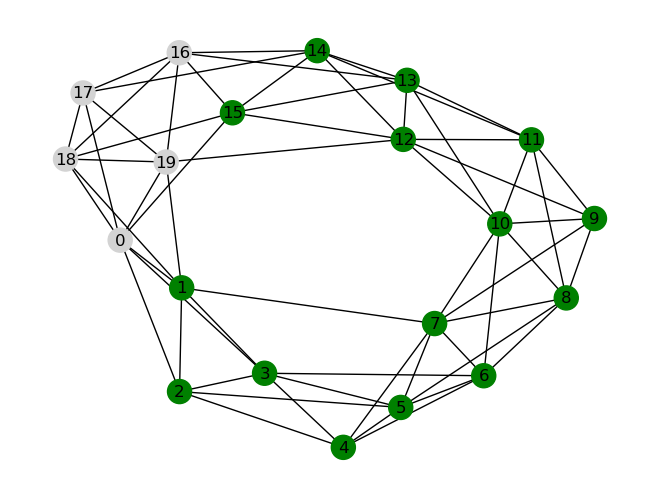

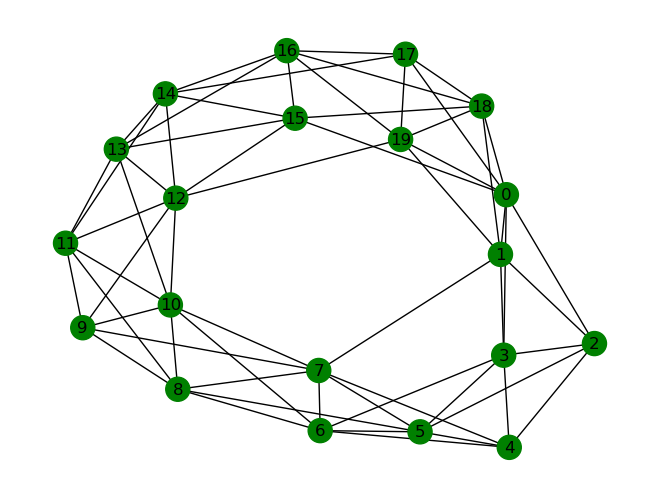

In [98]:
seed = 0
model = MotivatingExampleModel(seed=seed, initial_recycling_rate=0.1, landfill_costs=1.2, 
                               decision_weights={'costs': -0.5, 'peers': 0.5})

# Run the model for ten steps.
for i in range(10):
    if i == 0 or i == 1 or i == 4 or i == 8:
        cmap = []
        for a in model.asset_owners_schedule.agents:
            if a.recycling:
                cmap.append('green')
            else:
                cmap.append('lightgrey')
        # Plot networks.
        nx.draw(model.network, node_color=cmap, with_labels=True)
        plt.show()
    model.step()


Obviously, **different network configurations** lead to different results... For instance, a regular lattice:

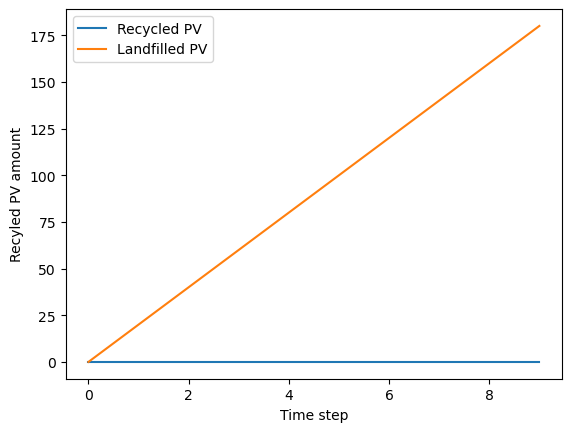

In [99]:
seed = 0
model = MotivatingExampleModel(seed=seed, initial_recycling_rate=0.1, landfill_costs=1.2, 
                               decision_weights={'costs': -0.5, 'peers': 0.5}, 
                               social_network={'node_degree': 7, 'rewiring_prob': 0.0})
recycled_pv = []
landfilled_pv = []

# Run the model for ten steps.
for i in range(10):
    recycled_pv.append(model.pv_waste_flows['recycling'])
    landfilled_pv.append(model.pv_waste_flows['landfill'])
    model.step()

# Plot results.
plt.plot(recycled_pv, label='Recycled PV')
plt.plot(landfilled_pv, label='Landfilled PV')
plt.xlabel('Time step')
plt.ylabel('Recyled PV amount')
plt.legend()

Or a random network:

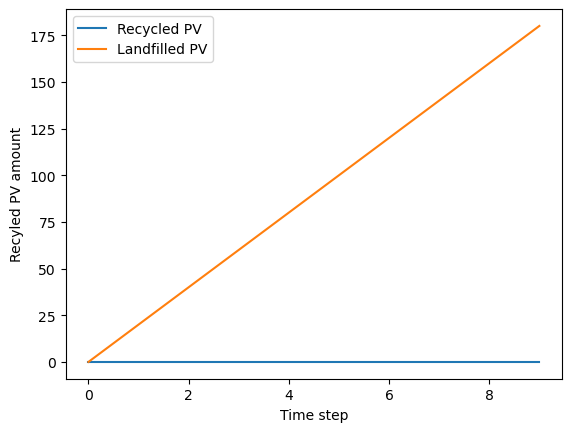

In [100]:
seed = 0
model = MotivatingExampleModel(seed=seed, initial_recycling_rate=0.1, landfill_costs=1.2, 
                               decision_weights={'costs': -0.5, 'peers': 0.5}, 
                               social_network={'node_degree': 7, 'rewiring_prob': 1.0})
recycled_pv = []
landfilled_pv = []

# Run the model for ten steps.
for i in range(10):
    recycled_pv.append(model.pv_waste_flows['recycling'])
    landfilled_pv.append(model.pv_waste_flows['landfill'])
    model.step()

# Plot results.
plt.plot(recycled_pv, label='Recycled PV')
plt.plot(landfilled_pv, label='Landfilled PV')
plt.xlabel('Time step')
plt.ylabel('Recyled PV amount')
plt.legend()

Or a different average degree:

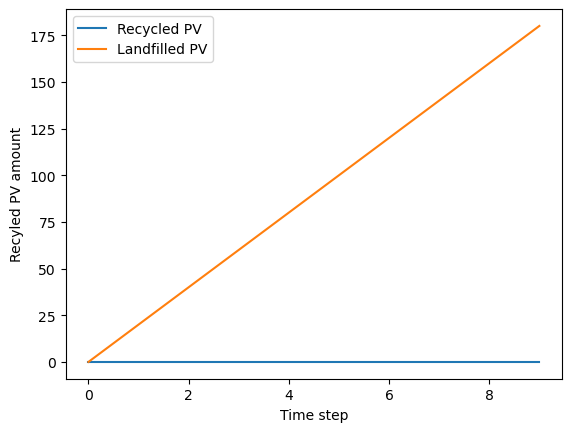

In [101]:
seed = 0
model = MotivatingExampleModel(seed=seed, initial_recycling_rate=0.1, landfill_costs=1.2, 
                               decision_weights={'costs': -0.5, 'peers': 0.5}, 
                               social_network={'node_degree': 20, 'rewiring_prob': 0.1})
recycled_pv = []
landfilled_pv = []

# Run the model for ten steps.
for i in range(10):
    recycled_pv.append(model.pv_waste_flows['recycling'])
    landfilled_pv.append(model.pv_waste_flows['landfill'])
    model.step()

# Plot results.
plt.plot(recycled_pv, label='Recycled PV')
plt.plot(landfilled_pv, label='Landfilled PV')
plt.xlabel('Time step')
plt.ylabel('Recyled PV amount')
plt.legend()

Alternatively, a landfill costs at parity but a higher initial recycling rate (0.14 rather than 0.1) can cause agents to adopt recycling behaviors.

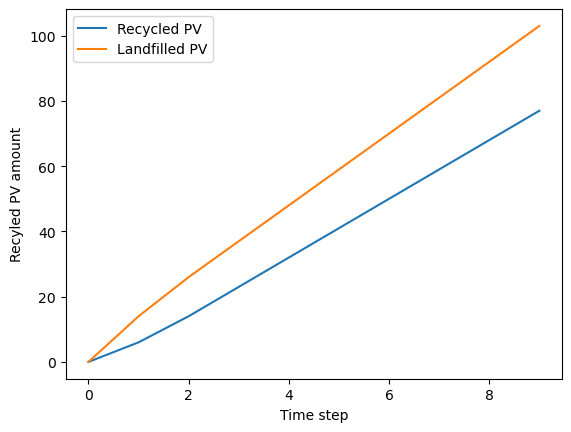

In [102]:
seed = 0
model = MotivatingExampleModel(seed=seed, initial_recycling_rate=0.14, landfill_costs=1, 
                               decision_weights={'costs': -0.5, 'peers': 0.5})
recycled_pv = []
landfilled_pv = []

# Run the model for ten steps.
for i in range(10):
    recycled_pv.append(model.pv_waste_flows['recycling'])
    landfilled_pv.append(model.pv_waste_flows['landfill'])
    model.step()

# Plot results.
plt.plot(recycled_pv, label='Recycled PV')
plt.plot(landfilled_pv, label='Landfilled PV')
plt.xlabel('Time step')
plt.ylabel('Recyled PV amount')
plt.legend()

**Now, where would the RTN be useful to the ABM?.** In my opinion the RTN would provide the *environmental conditions* for the ABM simulations; meaning, it would provide, for instance, the recycling (and transportation) costs of the optimized reverse supply chain under constraints (e.g., annual recycling capacity for a given location). Through PVICE, the ABM will provide the annual amount of PV waste to the RTN. See pseudo-code below.

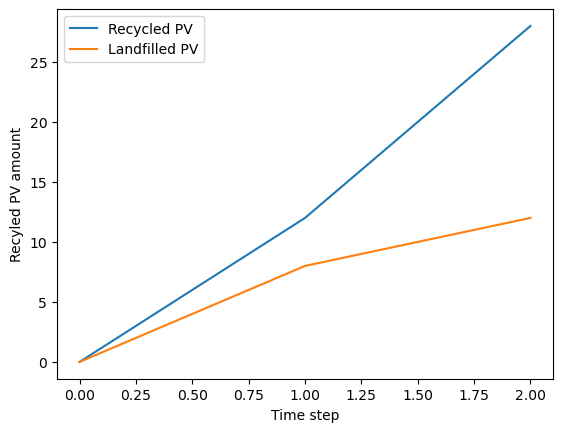

In [103]:
# run RTN
# Outputs stored or directly fed into the ABM
# For example for the recycling costs: 
#   year 1: recycling_center_costs={'Fabtech': 1, 'First Solar': 2, 'WERECYCLESOLAR': 3}
#   year 2: recycling_center_costs={'Fabtech': 2, 'First Solar': 1, 'WERECYCLESOLAR': 1}
#   year 3: recycling_center_costs={'Fabtech': 1, 'First Solar': 0.9, 'WERECYCLESOLAR': 1.1}

rtn_outputs = [{'Fabtech': 0.6, 'First Solar': 2, 'WERECYCLESOLAR': 3}, 
               {'Fabtech': 0.7, 'First Solar': 1.2, 'WERECYCLESOLAR': 2.5}, 
               {'Fabtech': 0.6, 'First Solar': 0.5, 'WERECYCLESOLAR': 2}]

seed = 0
model = MotivatingExampleModel(seed=seed, initial_recycling_rate=0.14, landfill_costs=1, 
                               decision_weights={'costs': -0.5, 'peers': 0.5})
recycled_pv = []
landfilled_pv = []

# Run the model for the number of steps in the rtn.
for i in range(len(rtn_outputs)):
    recycled_pv.append(model.pv_waste_flows['recycling'])
    landfilled_pv.append(model.pv_waste_flows['landfill'])
    model.recycling_center_costs = list(rtn_outputs[i].values())
    model.step()

# Plot results.
plt.plot(recycled_pv, label='Recycled PV')
plt.plot(landfilled_pv, label='Landfilled PV')
plt.xlabel('Time step')
plt.ylabel('Recyled PV amount')
plt.legend()